**@juliaroquette 7 Feb 2024**: Testing a few blackbody implementations. 

# Comparing a few implementations

Here I am comparing my own implementation of equation (7) with the Black Body models available in two different python packaged affiliated to astropy. 

In [1]:
import astropy.units as u
import astropy.constants as q
import numpy as np
import matplotlib.pyplot as plt
# for comparison     https://docs.astropy.org/en/stable/modeling/physical_models.html
from astropy.modeling.models import BlackBody
# for comparison https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#synphot-planck-law
from synphot import SourceSpectrum
import synphot.units as us
from synphot.models import BlackBodyNorm1D


/Users/juliaroquette/anaconda3/envs/NEMESIS/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(q.h)
print('in cgs: ', q.h.to(u.cm**2 * u.g / u.s))

  Name   = Planck constant
  Value  = 6.62607015e-34
  Uncertainty  = 0.0
  Unit  = J s
  Reference = CODATA 2018
in cgs:  6.62607015e-27 cm2 g / s


In [3]:
print(q.c)
print('in cgs: ', q.c.to(u.cm / u.s))

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2018
in cgs:  29979245800.0 cm / s


In [4]:
print(q.k_B)
print('in cgs: ', q.k_B.to(u.erg / u.K))

  Name   = Boltzmann constant
  Value  = 1.380649e-23
  Uncertainty  = 0.0
  Unit  = J / K
  Reference = CODATA 2018
in cgs:  1.380649e-16 erg / K


In [7]:
Teff = 10000 * u.K

In [8]:
wl = 1e-2 * u.cm
print('in cgs: ', wl.to(u.cm))

in cgs:  0.01 cm


In [9]:
def myBlackBody(wl, Teff):
    """
    Equation (7)
    """
    assert wl.decompose().unit == u.m
    assert Teff.unit == u.K
    B = (2. * q.h * q.c**2 / wl**5) * 1 / (np.exp(q.h * q.c / (wl * q.k_B * Teff)) - 1)
    return B.to(u.W/u.m**2/u.m)

In [10]:
def astropyBlackBody(wl, Teff):
    """
    https://docs.astropy.org/en/stable/modeling/physical_models.html
    The scaler will define the units of the output
    """
    scale = 1.*u.erg/u.s/u.cm**2/u.AA/u.sr
    bb = BlackBody(temperature=Teff, scale=scale)
    return bb(wl).to(u.erg/u.s/u.cm**2/u.um/u.sr)*u.sr #needs this transformation to match the units

In [11]:
def synphotBlackBody(wl, Teff):
    """
    https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#synphot-planck-law
    """
    FLAM = 1.*u.erg/u.s/u.cm**2/u.AA
    sp = SourceSpectrum(BlackBodyNorm1D, temperature=Teff)
    d = 1e3*u.pc
    R_sun = q.R_sun
    omega = (np.pi * (R_sun/d)**2).decompose()
    return FLAM*us.convert_flux(wl, sp(wl), us.FLAM).value/omega

In [12]:
omega = (np.pi * (q.R_sun/500)**2).decompose()
print(omega)


6082104402130.212 m2


In [13]:
print('my version:', myBlackBody(wl, Teff))
print('my version:', myBlackBody(wl, Teff).to(u.erg/u.s/u.cm**2/u.um))

my version: 821875.3801549723 W / m3
my version: 821.8753801549723 erg / (s um cm2)


In [14]:
print('Astropy',astropyBlackBody(wl, Teff))

Astropy 821.8753801549691 erg / (s um cm2)


In [15]:
print('synphot',synphotBlackBody(wl, Teff).to(u.erg/u.s/u.cm**2/u.um))

synphot 821.8753801549689 erg / (s um cm2)


In [16]:
def equation8(wl, Teff, BlackBody):
    assert wl.unit == u.um
    assert Teff.unit == u.K
    bb_result = BlackBody(wl, Teff).to(u.erg/u.s/u.cm**2/u.um)
    return np.log10((wl * np.pi * bb_result).value)

In [17]:
bb_dict = {'Mine': myBlackBody, 'Astropy': astropyBlackBody, 'Synphot': synphotBlackBody}
for bb in bb_dict.keys():
    print(bb, equation8(wl.to(u.um), Teff, bb_dict[bb]))

Mine 5.411955843745104
Astropy 5.411955843745102
Synphot 5.411955843745102


## testing against some non-python implementation

This online calculator https://www.spectralcalc.com/blackbody_calculator/blackbody.php
returns 0.821881 W/m2/sr/µm for a 10,000K Black-Body at 100$\mu$m= 1e-2 cm.


In [18]:
test = 0.821881*u.W/u.m**2/u.um/u.sr
print(test.to(u.erg/u.s/u.cm**2/u.um/u.sr))

821.881 erg / (s sr um cm2)


# Make a plot

In [19]:
# wl_array = np.linspace(0.1, 1000, 10000)*u.um
wl_array = np.linspace(0.1, 1000, 10000)*u.um

In [20]:
wl_array.to(u.cm)

<Quantity [1.000e-05, 2.000e-05, 3.000e-05, ..., 9.998e-02, 9.999e-02,
           1.000e-01] cm>

Text(0, 0.5, '$\\log_{10}[erg/s/cm^2]$')

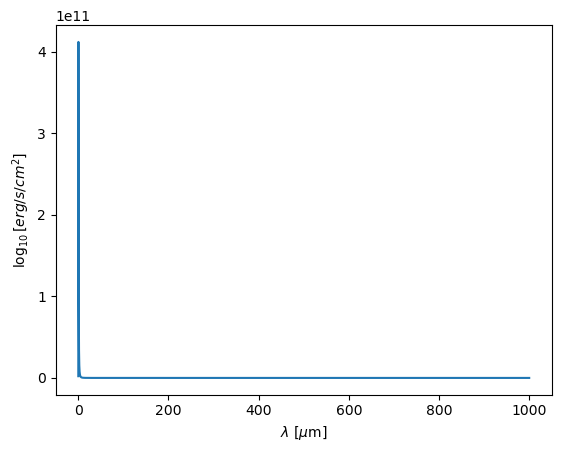

In [23]:
plt.plot(wl_array,#.to(u.um), 
         10**equation8(wl_array, Teff, myBlackBody))
plt.xlabel('$\lambda$ [$\mu$m]')
plt.ylabel('$\log_{10}[erg/s/cm^2]$')

Text(0, 0.5, '$\\log_{10}[erg/s/cm^2]$')

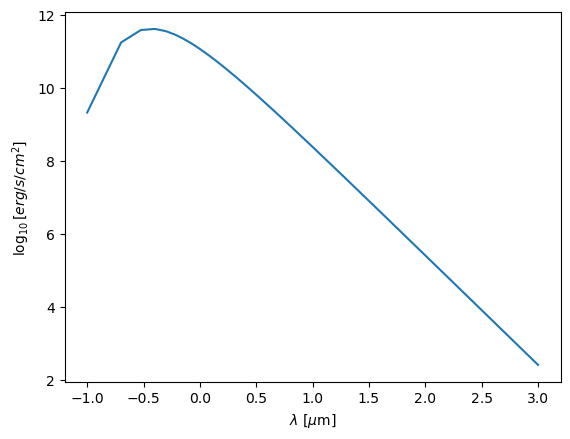

In [22]:
plt.plot(np.log10(wl_array.to(u.um).value), equation8(wl_array, Teff, myBlackBody))
plt.xlabel('$\lambda$ [$\mu$m]')
plt.ylabel('$\log_{10}[erg/s/cm^2]$')

# Getting conversion constants:

In `myBlackBody` I am using `astropy.units` to make sure that the units are converted correctly. I suppose that in `Julia` you will need the conversion values to debug:

In [84]:
wl_ = 1e-2 # u.cm
wl.to(u.cm)

<Quantity 0.01 cm>

In [85]:
Teff_ = 10000 # u.K
Teff.to(u.K)

<Quantity 2500. K>

In [86]:
h = 6.62607015e-27 # erg s
q.h.to(u.erg*u.s)

<Quantity 6.62607015e-27 erg s>

In [87]:
c = 29979245800.0 # cm / s
q.c.to(u.cm/u.s)

<Quantity 2.99792458e+10 cm / s>

In [88]:
k_B = 1.380649e-16 # erg / K
q.k_B.to(u.erg/u.K)

<Quantity 1.380649e-16 erg / K>

In [89]:
B = (2. * h * c**2 / wl_**5) * 1 / (np.exp(h * c / (wl_ * k_B * Teff_)) - 1)
print(B)

8218753.801549724


In [90]:
(2. * q.h.to(u.erg* u.s) * q.c.to(u.cm/u.s)**2 / wl.to(u.cm)**5) * 1 / (np.exp(q.h.to(u.cm**2 * u.g / u.s) * q.c.to(u.cm / u.s) / (wl.to(u.cm) * q.k_B.to(u.erg / u.K) * Teff.to(u.K))) - 1)

<Quantity 2010559.82160616 erg / (s cm3)>

For `equation8` we now have a $\pi\lambda$ multiplication terms, and the $\log_{10}$ operation.

In [94]:
(2. * q.h.to(u.erg* u.s) * q.c.to(u.cm/u.s)**2 / wl.to(u.cm)**5) * 1 / (np.exp(q.h.to(u.cm**2 * u.g / u.s) * q.c.to(u.cm / u.s) / (wl.to(u.cm) * q.k_B.to(u.erg / u.K) * Teff.to(u.K))) - 1)*np.pi * wl.to(u.cm)

<Quantity 63163.59965161 erg / (s cm2)>

In [93]:
np.log10(((2. * q.h.to(u.erg* u.s) * q.c.to(u.cm/u.s)**2 / wl.to(u.cm)**5) * 1 / (np.exp(q.h.to(u.cm**2 * u.g / u.s) * q.c.to(u.cm / u.s) / (wl.to(u.cm) * q.k_B.to(u.erg / u.K) * Teff.to(u.K))) - 1)*np.pi * wl.to(u.cm)).value)

4.800466872195709

# The proof: 

Plotting data and model. Note that we need a multiplicative constant together with the Planck curve in order to account for distance and reddening. 

In [40]:
nu_Fnu = np.array([1.61e-11, 2.18e-11, 3.98e-11, 4.51e-11, 6.60e-11, 8.08e-11, 
          1.44e-10, 1.61e-10, 1.05e-10, 3.48e-11, 3.08e-11, 1.57e-11, 
          1.42e-11, 8.59e-12, 3.71e-12])
lamb = np.array([0.503575, 0.546757, 0.582239, 0.635735, 0.761996,
                 0.782865, 1.235, 1.662, 2.159, 3.3526, 3.537841, 
                 4.478049, 4.6028, 5.696178, 7.79784])

Text(0, 0.5, '$\\log_{10}[erg/s/cm^2]$')

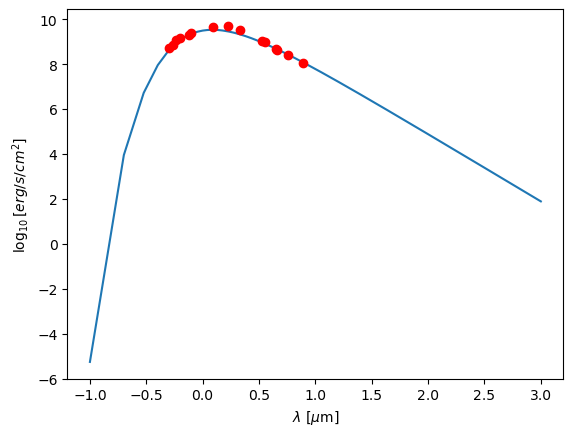

In [52]:
norm=1e11
Teff = 3000*u.K
plt.plot(np.log10(wl_array.to(u.um).value), equation8(wl_array, Teff, myBlackBody))
plt.plot(np.log10(lamb), np.log10(norm*nu_Fnu*dist_term) , 'ro')
plt.xlabel('$\lambda$ [$\mu$m]')
plt.ylabel('$\log_{10}[erg/s/cm^2]$')

Text(0, 0.5, '$\\log_{10}[erg/s/cm^2]$')

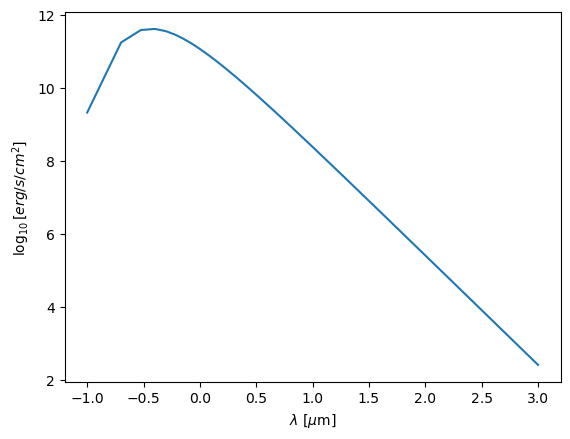

In [54]:
Teff = 10000*u.K
plt.plot(np.log10(wl_array.to(u.um).value), equation8(wl_array, Teff, myBlackBody))
plt.xlabel('$\lambda$ [$\mu$m]')
plt.ylabel('$\log_{10}[erg/s/cm^2]$')

# Niko's version (in Julia)

```Julia
function buildingblock(λ, T) # implements equation 8 in overleaf

	# λ is in cm
	# T is in Kelvin

    # copied from overleaf
    # • Planck’s constant,  h = 6.62607015e − 27 in cm2 · g/s
    # • Speed of light,     c = 299792458e10 in cm/s,
    # • Boltzmann constant, k = 1.380649e − 16 in erg/K
    
    local h = 6.62607015e-27
    local c = 299792458e10
    local k = 1.380649e-16

	# WRONG!
    # log10(2π) + log10(h) + 2*(log10(c)) - 4*log10(λ) - ((h*c/(λ*k*T)) - 1)/log(10.0)

	# corrected version below
	# logexpm1 is the numerically stable version of log(exp(x) - 1)
	# (Python equivalent of logexpm1 is probably something like math.log1p)
	log10(2π) + log10(h) + 2*(log10(c)) - 4*log10(λ) - logexpm1(h*c/(λ*k*T))/log(10.0)
end
```

In [37]:
h = 6.62607015e-27
c = 299792458e10
k = 1.380649e-16
wl=0.01
Teff = 10000.
np.exp(h*c/(wl*k*Teff))

/var/folders/3v/wynxxyd55nq14hvn15_n_f400000gn/T/ipykernel_26075/1080353062.py:6: RuntimeWarning: overflow encountered in exp
  np.exp(h*c/(wl*k*Teff))


inf

In [32]:
def buildingblock(wl, Teff): # implements equation 8 in overleaf
    h = 6.62607015e-27
    c = 299792458e10
    k = 1.380649e-16
    return np.log10(2 * np.pi) + np.log10(h) + 2.*(np.log10(c)) - 4.*np.log10(wl) - np.log(np.expm1(h*c/(wl*k*Teff)))/np.log(10.0)

In [33]:
buildingblock(wl.to(u.cm).value, Teff.value)

/var/folders/3v/wynxxyd55nq14hvn15_n_f400000gn/T/ipykernel_26075/221573922.py:5: RuntimeWarning: overflow encountered in expm1
  return np.log10(2 * np.pi) + np.log10(h) + 2.*(np.log10(c)) - 4.*np.log10(wl) - np.log(np.expm1(h*c/(wl*k*Teff)))/np.log(10.0)


-inf

# SEDan version


Below you will find the version Kai built for `SEDan`. He's working in SI. However, the important point here is that he's simply normalizing everything to have the maximum at 1. 

```python
import torch

H = 6.62606957e-34 # Js
C = 299792458 # m/s
K_B = 1.3806488e-23 # J/K
B_NU = 5.878933*1.e10 # Hz/K
B_LAMBDA = 2.8977685*1e-3 # m * K

def planck_curve_f_lambda(temperature, wavelength):
    """ Calculates the Planck equation for a given temperature and wavelength.

    Args:
        temperature (float32): Temperature in Kelvin. Could also be a tensor of values.
        wavelength (float32): Wavelength in meter. Could also be a tensor of values.

    Returns:
        float32: The result of the Planck function for given temperature and wavelength.
    """    
    return 2.0 * H * C**2 / wavelength**5 / (torch.exp(H * C / wavelength / K_B / temperature) - 1)

def normalized_planck_Curve_f_lambda(temperature, wavelength): # wavelength in meter
    return planck_curve_f_lambda(temperature, wavelength) / planck_curve_f_lambda(temperature, B_LAMBDA/temperature)

def planck_curve_f_nu(temperature, frequency): # frequency in hz
    return 2.0 * H * 1.e18 * (frequency * 1.e-6)**3 /  C**2 / (torch.exp(H * frequency / K_B / temperature) - 1)

def norm_planck_curve_f_nu(temperature, frequency): # frequency in hz
    return planck_curve_f_nu(temperature, frequency) / planck_curve_f_nu(temperature, B_NU*temperature)
'''